<a href="https://www.kaggle.com/code/wasswassss/xgboost-on-home-data?scriptVersionId=120225132" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Table of Contents

- 1 [Importing data / Specifying features and target](#1)
- 2 [Data pre-processing](#2)
    - 2.1 [Encoding categorical columns](#2.1)
    - 2.2 [Handling missing values](#2.2)
- 3 [Building the model](#3)
    - 3.1 [DMatrix](#3.1)
    - 3.2 [Spliting the data](#3.2)
    - 3.3 [Model setting / parameters](#3.3)
- 4 [Testing model's perf](#4)
    - 4.1 [Computing MAE](#4.1)
    - 4.2 [ Hyperparameters tuning using HYPEROPT](#4.2)
    - 4.3 [K-fold Cross Validation](#4.3)
    - 4.4 [Feature importance](#4.4)

# **1. Importing data / Specifying features and target** <a class="anchor" id="1"></a>

In [1]:
import numpy as np 
import pandas as pd 
#importing the database
data=pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
data2=data.copy()
#droping rows with missing target value
data.dropna(axis=0, subset=['SalePrice'],inplace=True)

#Defining the target
y=data.SalePrice
#Defining the features + Dropping columns with more than 80% of NA Values
data.drop(['SalePrice','Alley','Fence','MiscFeature','PoolQC'],axis=1,inplace=True)

# **2. Data pre-processing** <a class="anchor" id="2"></a>

### **2.1. Encoding categorical columns** <a class="anchor" id="2.1"></a>
We need to verify whether there are any categorical columns in our dataset that require conversion to numerical format.

In [2]:
categorical_columns=[col for col in data.columns
                     if (data[col].dtype=='O')]
categorical_columns

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [3]:
# Before hot encoding
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,61,0,0,0,0,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,42,0,0,0,0,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,84,0,0,0,0,0,12,2008,WD,Normal


In [4]:
# After applying hot encoding
data=pd.get_dummies(data)
data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0


In [5]:
# Checking if there are any missing values
data.isnull().any()
# We can notice that some columns have NA values such as 'LotFrontage'

Id                       False
MSSubClass               False
LotFrontage               True
LotArea                  False
OverallQual              False
                         ...  
SaleCondition_AdjLand    False
SaleCondition_Alloca     False
SaleCondition_Family     False
SaleCondition_Normal     False
SaleCondition_Partial    False
Length: 276, dtype: bool

### **2.2. Handling missing values** <a class="anchor" id="2.2"></a>
Instead of droppign rows or columns with missing values, I chose to perform imputation. The SimpleImputer class, by default, fills in the missing values with the **mean** of the non-missing values in each respective column. 

In [6]:
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer()
imputed_data = pd.DataFrame(my_imputer.fit_transform(data))

#sets the column names of the imputed_data DataFrame to be the same as the column names of the original data DataFrame
#This is necessary because the fit_transform() method returns an array, which doesn't have column names.
imputed_data.columns=data.columns

In [7]:
# Checking 
imputed_data.isnull().any().any()
# The 'False' returned means that there is no single missing value in our dataset at this point

False

In [8]:
#Since we dropped rows with missing prices, the labels have no NA values
y.isnull().any()

False

# **3. Building the model** <a class="anchor" id="3"></a>

### **3.1 DMatrix** <a class="anchor" id="3.1"></a>
The **DMatrix** object stores the input features in a compressed format that is optimized for efficient computation during training and prediction. 

In [9]:
# import XGBoost
import xgboost as xgb
# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=imputed_data,label=y)

### **3.2 Spliting the dataset** <a class="anchor" id="3.2"></a>

In [10]:
from sklearn.model_selection import train_test_split
# We're perforiming the training on 80% of the dataset
X_train, X_valid, y_train, y_valid = train_test_split(imputed_data, y, train_size=0.8, test_size=0.2,random_state=0)

### **3.3 Model settings / hyparameters** <a class="anchor" id="3.3"></a>
The XGBoost model is configured using the following parameters:

- `max_depth`: sets the maximum depth of each tree in the model.
- `learning_rate`: sets the step size of the gradient descent algorithm used to train the model.
- `subsample`: sets the fraction of training data to use for each tree in the model.
- `colsample_bytree`: sets the fraction of features to use for each tree in the model.
- `objective`: sets the loss function to be optimized during model training.
- `n_estimators`: sets the number of trees to build in the model.


In [11]:
from xgboost import XGBRegressor

params = {
    'max_depth': 5,
    'learning_rate': 0.03,
    'subsample': 0.5,
    'colsample_bytree': 0.3,
    'objective': 'reg:squarederror',
    'n_estimators':1000
}

xgb_clf = XGBRegressor(**params)
xgb_clf.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

# **4. Testing model's performance** <a class="anchor" id="4"></a>

### **4.1 Computing MAE** <a class="anchor" id="4.1"></a>

The mean absolute error (MAE) is a common evaluation metric used in **regression** analysis. It measures the **average absolute difference** between the predicted and actual values of the target variable. In other words, it measures how far off the predictions are on average.

In [12]:
from sklearn.metrics import mean_absolute_error

# Predicted values
y_pred = xgb_clf.predict(X_valid)


print('The model MAE is:'+str(mean_absolute_error(y_valid, y_pred)) )

The model MAE is:15166.699004708904


### **4.2 Hyperparameters tuning using HYPEROPT** <a class="anchor" id="4.2"></a>
HYPERPLOT is a library that helps to determine the best hyperparameters for a model by testing different values for each hyperparameter.

In [13]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space1 = {
    'max_depth': hp.uniform("max_depth",1,18),
    'learning_rate':hp.uniform('learning_rate',0,1),
    'subsample': hp.uniform('subsample',0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
    'objective': 'reg:squarederror',
    'n_estimators': hp.uniform('n_estimators',100,2000)
}

In [14]:
def objective(space1):
    clf = xgb.XGBRegressor(
                    n_estimators=int(space1['n_estimators']), 
                    max_depth=int(space1['max_depth']), 
                    colsample_bytree=space1['colsample_bytree'],
                    subsample=space1['subsample'],
                    objective=space1['objective'],
                    learning_rate=space1['learning_rate'])
    
    clf.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            eval_metric="mae",verbose=False,early_stopping_rounds=10
            )
    
    pred = clf.predict(X_valid)
    mae = mean_absolute_error(y_valid, pred)
    print ("SCORE:", mae)
    return {'loss': mae, 'status': STATUS_OK }

In [15]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space1,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
32435.979338345463
  1%|          | 1/100 [00:00<00:28,  3.46trial/s, best loss: 32435.979338345463]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
20837.621481699487
  2%|▏         | 2/100 [00:00<00:39,  2.47trial/s, best loss: 20837.621481699487]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
21679.01162510702
  3%|▎         | 3/100 [00:01<00:56,  1.71trial/s, best loss: 20837.621481699487]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
24900.267665079195
  4%|▍         | 4/100 [00:01<00:46,  2.08trial/s, best loss: 20837.621481699487]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
27567.526327054795
SCORE:
  5%|▌         | 5/100 [00:02<00:39,  2.39trial/s, best loss: 20837.621481699487]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



35446.261584974316
  6%|▌         | 6/100 [00:02<00:33,  2.79trial/s, best loss: 20837.621481699487]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16842.215071168663
  7%|▋         | 7/100 [00:03<00:59,  1.57trial/s, best loss: 16842.215071168663]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
18688.154082833906
  8%|▊         | 8/100 [00:06<02:01,  1.32s/trial, best loss: 16842.215071168663]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
26268.79196208797
  9%|▉         | 9/100 [00:06<01:32,  1.01s/trial, best loss: 16842.215071168663]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17803.13207673373
 10%|█         | 10/100 [00:07<01:32,  1.03s/trial, best loss: 16842.215071168663]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
28304.85645869007
 11%|█         | 11/100 [00:08<01:14,  1.20trial/s, best loss: 16842.215071168663]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
29353.03524989298
 12%|█▏        | 12/100 [00:08<01:02,  1.41trial/s, best loss: 16842.215071168663]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19028.56888110017
 13%|█▎        | 13/100 [00:09<01:17,  1.12trial/s, best loss: 16842.215071168663]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
31982.576683566997
 14%|█▍        | 14/100 [00:10<01:01,  1.41trial/s, best loss: 16842.215071168663]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
28482.64991572132
 15%|█▌        | 15/100 [00:10<00:49,  1.70trial/s, best loss: 16842.215071168663]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
21556.30920911815
 16%|█▌        | 16/100 [00:11<00:47,  1.76trial/s, best loss: 16842.215071168663]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16222.845408818494
 17%|█▋        | 17/100 [00:16<02:43,  1.97s/trial, best loss: 16222.845408818494]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
26295.582539597603
 18%|█▊        | 18/100 [00:16<02:01,  1.48s/trial, best loss: 16222.845408818494]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
31343.503397902397
 19%|█▉        | 19/100 [00:17<01:32,  1.14s/trial, best loss: 16222.845408818494]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
18707.375561857876
 20%|██        | 20/100 [00:17<01:25,  1.06s/trial, best loss: 16222.845408818494]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
15752.264487906677
 21%|██        | 21/100 [00:44<11:22,  8.64s/trial, best loss: 15752.264487906677]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
15851.482823202055
 22%|██▏       | 22/100 [00:57<12:54,  9.92s/trial, best loss: 15752.264487906677]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
15508.283136237158
 23%|██▎       | 23/100 [01:08<13:28, 10.50s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
18453.944269049658
 24%|██▍       | 24/100 [01:10<09:59,  7.89s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17565.206255351026
 25%|██▌       | 25/100 [01:12<07:22,  5.90s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16690.423252889555
 26%|██▌       | 26/100 [01:14<05:59,  4.85s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19603.356298159248
 27%|██▋       | 27/100 [01:15<04:35,  3.78s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
15703.640758775686
 28%|██▊       | 28/100 [01:20<04:54,  4.09s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
25443.81409193065
 29%|██▉       | 29/100 [01:21<03:36,  3.05s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
21036.28933005137
 30%|███       | 30/100 [01:22<02:55,  2.51s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
23824.62633775685
 31%|███       | 31/100 [01:23<02:14,  1.94s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
41602.17863067209
 32%|███▏      | 32/100 [01:23<01:47,  1.59s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
15854.518327268835
 33%|███▎      | 33/100 [01:29<03:09,  2.82s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
22416.74768568065
 34%|███▍      | 34/100 [01:30<02:21,  2.14s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17042.659808433218
 35%|███▌      | 35/100 [01:31<02:05,  1.92s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
33893.90568145334
 36%|███▌      | 36/100 [01:31<01:31,  1.43s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16210.66957405822
 37%|███▋      | 37/100 [01:50<07:05,  6.76s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
32836.97916443707
 38%|███▊      | 38/100 [01:51<04:58,  4.81s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16300.381555008562
 39%|███▉      | 39/100 [01:53<03:59,  3.93s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19159.902571168663
 40%|████      | 40/100 [01:53<02:57,  2.96s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
25327.04881474743
 41%|████      | 41/100 [01:54<02:11,  2.23s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19303.883855950342
 42%|████▏     | 42/100 [01:55<01:46,  1.83s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17549.234696061645
 43%|████▎     | 43/100 [01:56<01:30,  1.58s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
23596.72791363442
 44%|████▍     | 44/100 [01:57<01:18,  1.40s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19808.691874464897
 45%|████▌     | 45/100 [01:58<01:22,  1.50s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19299.892150042808
 46%|████▌     | 46/100 [02:00<01:16,  1.42s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
25767.71552600599
 47%|████▋     | 47/100 [02:00<01:00,  1.14s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
21747.396631528252
 48%|████▊     | 48/100 [02:01<00:50,  1.03trial/s, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
29604.721358625855
 49%|████▉     | 49/100 [02:01<00:40,  1.25trial/s, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
15935.359776327055
 50%|█████     | 50/100 [02:06<01:38,  1.97s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
23890.97086365582
 51%|█████     | 51/100 [02:06<01:15,  1.55s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16010.091770119863
 52%|█████▏    | 52/100 [02:08<01:22,  1.71s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
20903.91271136558
 53%|█████▎    | 53/100 [02:09<01:03,  1.35s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16900.12244488442
 54%|█████▍    | 54/100 [02:22<03:41,  4.82s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
18400.251297624145
 55%|█████▌    | 55/100 [02:23<02:49,  3.77s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
18517.479599208047
 56%|█████▌    | 56/100 [02:25<02:18,  3.14s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
25116.83175032106
 57%|█████▋    | 57/100 [02:26<01:45,  2.46s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
18798.03336365582
 58%|█████▊    | 58/100 [02:27<01:27,  2.08s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
33674.312780928936
 59%|█████▉    | 59/100 [02:27<01:05,  1.59s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
30465.051329730308
 60%|██████    | 60/100 [02:28<00:49,  1.23s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
35141.96867642337
 61%|██████    | 61/100 [02:28<00:36,  1.06trial/s, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
29177.027450770547
 62%|██████▏   | 62/100 [02:31<00:56,  1.48s/trial, best loss: 15508.283136237158]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
15080.257116866438
                                                                                  

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
28023.64061162243
 64%|██████▍   | 64/100 [02:34<00:54,  1.52s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
18235.31212542808
 65%|██████▌   | 65/100 [02:35<00:48,  1.38s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
15609.495264340754
 66%|██████▌   | 66/100 [02:39<01:11,  2.10s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
15952.94113869863
 67%|██████▋   | 67/100 [02:42<01:13,  2.24s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16917.448121789384
 68%|██████▊   | 68/100 [02:43<01:01,  1.91s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
18536.999692315923
 69%|██████▉   | 69/100 [02:44<00:51,  1.66s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
18643.287310038526
 70%|███████   | 70/100 [02:45<00:41,  1.37s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
15645.007357662671
 71%|███████   | 71/100 [02:48<00:53,  1.84s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16357.052239404966
 72%|███████▏  | 72/100 [02:50<00:55,  1.99s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
15446.733652611301
 73%|███████▎  | 73/100 [02:54<01:07,  2.51s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
21141.61064586901
 74%|███████▍  | 74/100 [02:54<00:49,  1.89s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
20176.079128317637
 75%|███████▌  | 75/100 [02:55<00:37,  1.52s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
22139.082780393837
 76%|███████▌  | 76/100 [02:56<00:30,  1.27s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19030.71227525685
 77%|███████▋  | 77/100 [03:08<01:48,  4.72s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
20910.164624357876
 78%|███████▊  | 78/100 [03:09<01:17,  3.53s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
22222.936831121577
 79%|███████▉  | 79/100 [03:10<01:00,  2.86s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19840.812018407534
 80%|████████  | 80/100 [03:11<00:44,  2.24s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
26181.97123822774
 81%|████████  | 81/100 [03:12<00:33,  1.76s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19404.48224796661
 82%|████████▏ | 82/100 [03:13<00:26,  1.48s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16183.589442422945
 83%|████████▎ | 83/100 [03:17<00:40,  2.36s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
120255.74682951627
 84%|████████▍ | 84/100 [03:26<01:11,  4.44s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16237.971305115581
 85%|████████▌ | 85/100 [03:27<00:51,  3.44s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
15610.101080907534
SCORE:
181369.88356164383
 87%|████████▋ | 87/100 [03:30<00:29,  2.26s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19614.913233090752
 88%|████████▊ | 88/100 [03:33<00:28,  2.39s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19853.747538527397
 89%|████████▉ | 89/100 [03:34<00:22,  2.07s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17005.740020333906
 90%|█████████ | 90/100 [03:35<00:17,  1.73s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
22585.894477739726
 91%|█████████ | 91/100 [03:35<00:11,  1.31s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19804.66158764983
 92%|█████████▏| 92/100 [03:36<00:08,  1.05s/trial, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
35088.46713131421
 93%|█████████▎| 93/100 [03:36<00:05,  1.22trial/s, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
33509.0661520762
 94%|█████████▍| 94/100 [03:36<00:04,  1.49trial/s, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16274.721813463186
 95%|█████████▌| 95/100 [03:37<00:03,  1.38trial/s, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
24357.879307577055
 96%|█████████▌| 96/100 [03:38<00:02,  1.48trial/s, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
26021.41174818065
 97%|█████████▋| 97/100 [03:38<00:01,  1.77trial/s, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17532.55610552226
 98%|█████████▊| 98/100 [03:40<00:01,  1.19trial/s, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
36749.520862318066
 99%|█████████▉| 99/100 [03:41<00:00,  1.10trial/s, best loss: 15080.257116866438]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
24332.057108839897
100%|██████████| 100/100 [03:41<00:00,  2.22s/trial, best loss: 15080.257116866438]


**Observation** We didn't get better results as hyperparameter tuning does not guarantee that the model's performance will improve ( we're going to try other parameters for the hyperopt in next versions)

### **4.3 K-fold Cross Validation** <a class="anchor" id="4.2"></a>
K-fold cross-validation is a technique used to assess the performance of the model. It involves **partitioning** the original dataset into k equally sized subsets, or "folds". One of these folds is held out as a validation set, while the remaining k-1 folds are used for training the model. By doing this we can chose see which partitioning of the dataset gives the best results

In [16]:
from xgboost import cv

# XGB Model parameters
params = {
    'max_depth': 5,
    'learning_rate': 0.03,
    'subsample': 0.5,
    'colsample_bytree': 0.3,
    'objective': 'reg:squarederror',
    'n_estimators':1000
}
xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=50,
            early_stopping_rounds=10, metrics="mae", as_pandas=True)

[22:29:10] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:29:10] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:29:10] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being use

In [17]:
xgb_cv

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,175641.222911,1035.126602,175651.360989,2096.245640
1,170502.680589,962.774100,170488.403018,2111.459691
2,165545.956200,888.993458,165514.317567,2132.877549
3,160670.480392,836.032535,160594.270420,2128.164149
4,155953.942187,784.206618,155878.774085,2111.253840
5,151394.221332,755.757634,151294.218397,2083.155046
6,146988.224124,707.054467,146882.233528,2052.925172
7,142718.727440,705.803816,142592.931122,1992.612201
8,138594.580912,681.710210,138470.788974,1943.498986
9,134505.927490,640.356872,134391.000602,1902.186687


### **4.4 Feature importance** <a class="anchor" id="4.3"></a>
XGBoost provides a way to examine the importance of each feature in the original dataset within the model.

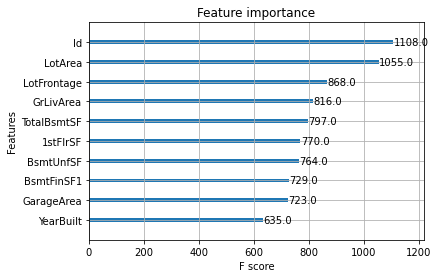

<Figure size 1152x720 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_clf, max_num_features=10)
plt.figure(figsize=(16, 10))
plt.show()

**Observation :** 
Here's what we've noticed: the features that seem to matter the most are the ones related to how much space there is, especially LotArea. That's the one with the biggest impact on the sale price, and you can see that clearly in the regression plot below because it has a strong positive relationship. 

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

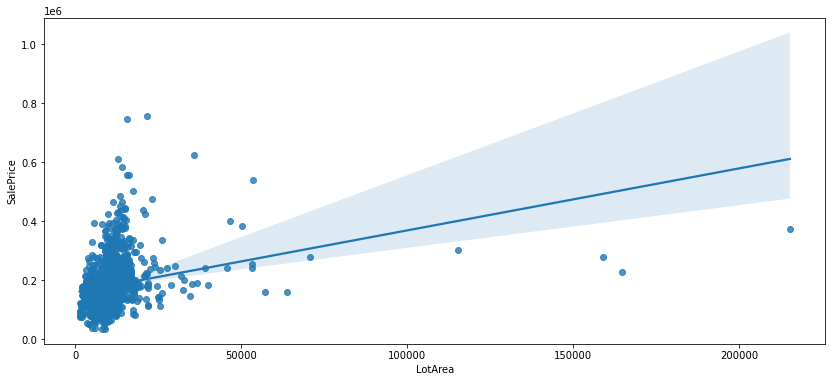

In [19]:
import seaborn as sns
plt.figure(figsize=(14,6))
sns.regplot(data=data2,x='LotArea',y='SalePrice')